# CAP 394-1 - Introdução à Data Science
### Eduardo Pereira de Sousa
## Tema: Decomposição de Software por meio do Acoplamento Semântico

A qualidade de um software pode ser medida por diferentes pontos de vista, dentre esses, a análise de métricas do código-fonte é um dos mais relevantes ao processo de desenvolvimento e manutenção.

Essas métricas expressam diferentes características do código-fonte, no caso de softwares orientados à objeto é comum o uso das métricas propostas por _Chidamber e Kemerer_, como: número de métodos por classe, acoplamento entre classes e coesão entre métodos de uma classe.

Essas métricas servem de base para diversas ferramentas e métodos de análise, como os _bad smells_, que são características de classes e métodos que podem indicar a ocorrência de problemas mais graves nesses componentes. Uma classe possui um determinado _bad smell_ caso suas métricas ultrapassem um conjunto pré-definido de limiares.

_Aniche et al._ mostrou que esses limiares podem ser mais eficientes na identificação dos _bad smells_ caso se considere o papel do componente na arquitetura do software na definição dos limiares sob os quais cada classe será avaliada.

A definição do papel arquitetural de uma determinada classe frente ao software que ela compõe é por si só uma questão em aberto, visto que o método aplicado por _Aniche et al._ baseia-se em características próprias dos _frameworks_ Spring MVC e Android, as quais não podem ser aplicadas de forma geral a outros softwares, ainda que desenvolvidos na mesma linguagem.

Nesse ponto, o trabalho de _Bavota et al._ evidencia um possível caminho na decomposição de sistemas de software por meio do acoplamento semântico de seus componentes. Seu trabalho aponta que o acoplamento semântico é aquele capaz de expressar com maior fidelidade a percepção dos próprios desenvolvedores, quando comparado a outros métodos de análise do acoplamento. O acoplamento semântico utiliza a similaridade do vocabulário de classes e métodos como forma de evidenciar as relações entre esses componentes.

Neste trabalho, exploraremos diferentes metodologias e técnicas para obtenção, visualização e análise do vocabulário, comparando essas abordagens quanto a capacidade de recuperar a decomposição original da aplicação em pacotes e segundo o método originalmente usado por Aniche et al. na análise de projetos desenvolvidos com o framework Spring MVC. Nosso objetivo é explorar e verificar o comportamento e os resultados obtidos com diferentes abordagens, além de explorar técnicas que permitam a visualização dos dados obtidos.


### Bibliografia

Aniche, M., Treude, C., Zaidman, A., Van Deursen, A., & Gerosa, M. A. (2016, October). SATT: Tailoring code metric thresholds for different software architectures. In Source Code Analysis and Manipulation (SCAM), 2016 IEEE 16th International Working Conference on (pp. 41-50). IEEE.

Bavota, G., Dit, B., Oliveto, R., Di Penta, M., Poshyvanyk, D., & De Lucia, A. (2013, May). An empirical study on the developers' perception of software coupling. In Proceedings of the 2013 International Conference on Software Engineering (pp. 692-701). IEEE Press.

Chidamber, S. R., & Kemerer, C. F. (1994). A metrics suite for object oriented design. IEEE Transactions on software engineering, 20(6), 476-493.

Poshyvanyk, D., Marcus, A., Ferenc, R., & Gyimóthy, T. (2009). Using information retrieval based coupling measures for impact analysis. Empirical software engineering, 14(1), 5-32.

## Clone GitHub Repository

In [9]:
import os
from git import Repo

In [10]:
# Set the project to be retrieved
project_org = 'spring-projects'
project_name = 'spring-petclinic'
# Where to store the repository locally
local_path = os.path.join('./repositories', project_org, project_name)
# From where to grab the repository
github_url = 'https://github.com/{}/{}.git'.format(project_org, project_name)

In [11]:
# Clone the repository
try:
    Repo.clone_from(github_url, local_path, depth=1)
except:
    print('repository already exists')

repository already exists


## Extract Corpus from Java Source Code

In [12]:
from sklearn.datasets.base import Bunch
import javalang
import glob
import io

In [13]:
tokens_to_grab = [javalang.tokenizer.Identifier]

In [14]:
def extract_corpus(token_list, after_line):
    corpus = []
    line_words = []
    line_number = 0
    for token in token_list:
        token_line = token.position[0]
        if token_line < after_line:
            continue
        if token_line > line_number:
            line_number = token_line
            if len(line_words) > 0:
                corpus.append(' '.join(line_words))
                line_words = []
        if type(token) in tokens_to_grab:
            line_words.append(token.value.strip())
    if len(line_words) > 0:
        corpus.append(' '.join(line_words))
    return '\n'.join(corpus)

def get_source_code(filename):
    f = io.open(filename, 'r', encoding="utf-8")
    source_code = f.read()
    f.close()
    return source_code

def in_project_path(project_path, file_path):
    return file_path[len(project_path):]

def get_project_corpus(project_path):
    data = []
    path = []
    for filename in glob.iglob(project_path + "/**/*.java", recursive=True):
        source_code = get_source_code(filename)
        try:
            ast = javalang.parse.parse(source_code)
            if len(ast.types) == 0:
                break
            start_line = ast.types[0].position[0]
            token_list = list(javalang.tokenizer.tokenize(source_code))
            path.append(in_project_path(project_path, filename))
            data.append(extract_corpus(token_list, start_line))
        except javalang.parser.JavaSyntaxError as e:
            print("Syntax error parsing {}".format(filename))
    
    return Bunch(data=data,
                path=path)

corpus = get_project_corpus(local_path)

In [15]:
print(corpus.path[15])
print(corpus.data[15])

/src/main/java/org/springframework/samples/petclinic/owner/VisitController.java
VisitController
VisitRepository visits
PetRepository pets
VisitController VisitRepository visits PetRepository pets
visits visits
pets pets
InitBinder
setAllowedFields WebDataBinder dataBinder
dataBinder setDisallowedFields
ModelAttribute
Visit loadPetWithVisit PathVariable petId Map String Object model
Pet pet pets findById petId
model put pet
Visit visit Visit
pet addVisit visit
visit
GetMapping
String initNewVisitForm PathVariable petId Map String Object model
PostMapping
String processNewVisitForm Valid Visit visit BindingResult result
result hasErrors
visits save visit


## WordCloud

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

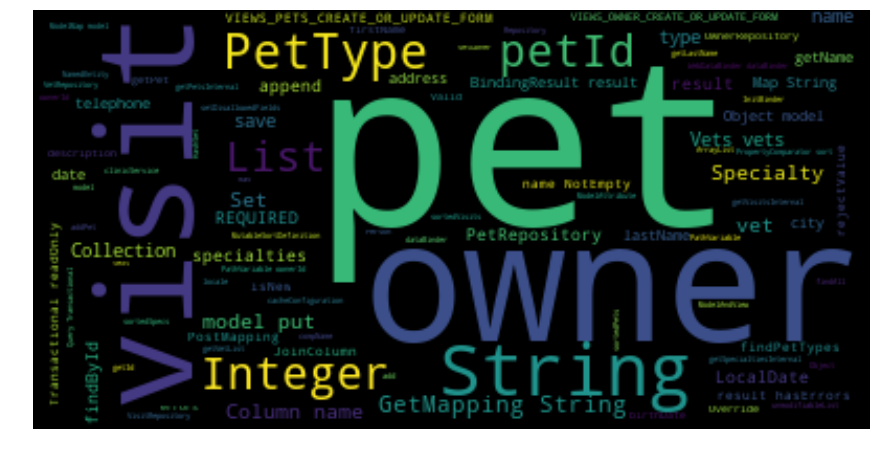

In [17]:
plt.rcParams['figure.figsize'] = [15, 10]
wc = wordcloud = WordCloud().generate(' '.join(corpus.data))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text Vectorizing

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
# Create sparse matrix of word frequencies
freq_vectorizer = TfidfVectorizer(analyzer='word', min_df = 0, use_idf=True)
freq_matrix =  freq_vectorizer.fit_transform(corpus.data)

In [20]:
sum_words = freq_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in freq_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
for word, freq in words_freq:
    print(word, freq)

pet 2.4345843395272775
string 2.0802454476657553
owner 2.0599227825101054
visit 1.9241525358150562
vets 1.794575823543827
pettype 1.463745132972012
namedentity 1.3276911740516146
integer 1.2870144777892143
pets 1.1993827600771216
specialty 1.1324586731821746
getmapping 1.0657802573676982
name 0.9947109077494739
transactional 0.9366568396808882
readonly 0.9366568396808882
vet 0.924531573755166
model 0.8367256154621905
list 0.8103750774986455
visits 0.7979264513357303
petid 0.7971899582018286
repository 0.7472053835008218
lastname 0.7191887754562227
serializable 0.6433393980135109
firstname 0.6340054128831433
welcome 0.6209425347600719
welcomecontroller 0.6209425347600719
required 0.6160981702949112
args 0.597908623629146
petclinicapplication 0.597908623629146
save 0.5968304782731011
cacheconfiguration 0.5789149491863353
object 0.5758705046152136
date 0.5653092444030456
type 0.564033233787536
specialties 0.5602781933791152
column 0.5430736780660652
dataaccessexception 0.5316640986371195


## Similarities

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = cosine_similarity(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

def most_similar(tfidf_matrix, index):
    return find_similar(tfidf_matrix, index, 1)[0]

In [22]:
for index, path in enumerate(corpus.path):
    most_similar_index, score = most_similar(freq_matrix, index)
    print('{} is {:.2f}% similar to {}'.format(path[53:], score*100, corpus.path[most_similar_index][53:]))

PetClinicApplication.java is 4.30% similar to model/Person.java
vet/Vet.java is 32.06% similar to vet/Specialty.java
vet/Specialty.java is 39.10% similar to owner/PetType.java
vet/VetRepository.java is 31.22% similar to owner/PetRepository.java
vet/VetController.java is 82.58% similar to vet/Vets.java
vet/Vets.java is 82.58% similar to vet/VetController.java
system/CrashController.java is 19.44% similar to system/WelcomeController.java
system/CacheConfiguration.java is 3.15% similar to owner/VisitController.java
system/WelcomeController.java is 19.44% similar to system/CrashController.java
visit/Visit.java is 23.19% similar to visit/VisitRepository.java
visit/VisitRepository.java is 52.84% similar to owner/VisitController.java
owner/OwnerRepository.java is 46.88% similar to owner/OwnerController.java
owner/PetTypeFormatter.java is 31.76% similar to owner/PetType.java
owner/OwnerController.java is 52.67% similar to owner/PetController.java
owner/Pet.java is 42.78% similar to owner/Visit

## Clustering

In [23]:
from sklearn.cluster import KMeans

In [24]:
number_of_clusters = 5
km = KMeans(n_clusters=number_of_clusters,init='k-means++', max_iter=100, n_init=1)
km.fit(freq_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
for i, c in enumerate(km.labels_):
    print(c, corpus.path[i][5:9], corpus.path[i][53:])

4 main PetClinicApplication.java
4 main vet/Vet.java
3 main vet/Specialty.java
2 main vet/VetRepository.java
1 main vet/VetController.java
1 main vet/Vets.java
1 main system/CrashController.java
0 main system/CacheConfiguration.java
1 main system/WelcomeController.java
4 main visit/Visit.java
4 main visit/VisitRepository.java
2 main owner/OwnerRepository.java
3 main owner/PetTypeFormatter.java
2 main owner/OwnerController.java
2 main owner/Pet.java
4 main owner/VisitController.java
0 main owner/Owner.java
0 main owner/PetController.java
3 main owner/PetType.java
2 main owner/PetRepository.java
0 main owner/PetValidator.java
4 main model/Person.java


In [26]:
print("Termos mais comuns por cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = freq_vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Termos mais comuns por cluster:
Cluster 0: pet required cacheconfiguration pets errors
Cluster 1: vets getmapping welcome welcomecontroller string
Cluster 2: owner transactional readonly integer pet
Cluster 3: namedentity pettype serializable specialty locale
Cluster 4: visit string petid firstname petclinicapplication


## Próximos Passos

1. Modificar opções de extração (stop words, separar identificadores compostos)
2. Extrair métricas CK.
3. Analisar métricas em diferentes agrupamentos (variar seed).